<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

Libraries needed: <i>numpy</i>, <i>matplotlib</i>, <i>keras</i> (this last one is needed to import the MNIST dataset. You can install it by following the guide at <a href="https://keras.io/">https://keras.io/</a>)

<h1> Bernoulli Mixture Model </h1>

Here I describe the Bernoulli mixture model and show how we can apply this model (together with the Expectation-Maximization (EM) algorithm) to classify (we'll see how well or how bad) hand written digits from the <a href="http://yann.lecun.com/exdb/mnist/">MNIST</a> database. In section (1) I describe the theory behind the model and I derive the update rules for the EM algorithm. In section (2) I implement the Bernoulli mixture model with EM optimization in Python. At last, in section (3) I show some results obtained with a faster code which I implemented in C++.

<h2> 1. Theory </h2>

Bernoully distribution for one $N$-dimensional data variable $\mathbf{x}$ which is a vector of binary values $x_i$:

\begin{align}\tag{1}
p(\mathbf{x}|\mu) = \prod_{n=1}^N\mu_n^{x_n}(1-\mu_n)^{1-x_n}
\end{align}

Both $\mathbf{x}$ and $\mu$ are row vectors in $\mathbb{R}^{N}$.

A finite mixture of such distributions is:

\begin{align}\tag{2}
p(\mathbf{x}|\mu,\pi)=\sum_{k=1}^K \pi_k p(\mathbf{x},\mu_k) = \sum_{k=1}^K \pi_k\prod_{n=1}^N\mu_{kn}^{x_n}(1-\mu_{kn})^{1-x_n}
\end{align}

where $\mu\in\mathbb{R}^{K\times N}$.

If we are given a dataset of $M$ vectors $\mathbf{x}_m$, we build the design matrix $X\in\mathbb{R}^{M\times N}$ and then the total probability ditribution will be given by

\begin{align}\tag{3}
p(X|\mu,\pi) = \prod_{m=1}^M\sum_{k=1}^K \pi_k p(X|\mu_k) = \prod_{m=1}^M\sum_{k=1}^K \pi_k\prod_{n=1}^N\mu_{kn}^{X_{mn}}(1-\mu_{kn})^{1-X_{mn}}
\end{align}

The log-likelihood is given by

\begin{align}\tag{4}
\log p(X|\mu,\pi) = \log\prod_{m=1}^M\sum_{k=1}^K \pi_k p(X|\mu_k) = \sum_{m=1}^M\log\sum_{k=1}^K \pi_k p(X|\mu_k) = \sum_{m=1}^M\log\left[\sum_{k=1}^K \pi_k\prod_{n=1}^N\mu_{kn}^{X_{mn}}(1-\mu_{kn})^{1-X_{mn}}\right]
\end{align}

<h4> Minimization with respect to $\mu$</h4>

Derivative with respect to $\mu_{ji}$:

\begin{align}\tag{5}
\frac{\partial \log p(X|\mu,\pi)}{\partial\mu_{ji}} = \sum_{m=1}^M\frac{1}{\sum_{q=1}^K \pi_q p(X|\mu_q)} \sum_{k=1}^K\pi_k\frac{\partial p(X|\mu_k)}{\partial \mu_{ji}}
\end{align}

For a given $m$, we also have

\begin{align}\tag{6}
\frac{\partial p(X|\mu_k)}{\partial \mu_{ji}} =&\ \frac{\partial }{\partial \mu_{ji}}\prod_{n=1}^N\mu_{kn}^{X_{mn}}(1-\mu_{kn})^{1-X_{mn}}\\
=&\ \delta_{kj}\prod_{n\neq i}^N \mu_{kn}^{X_{mn}}(1-\mu_{kn})^{1-X_{mn}}\left[X_{mi}\mu_{ki}^{X_{mi}-1}(1-\mu_{ki})^{1-X_{mi}}-\mu_{ki}^{X_{mi}}(1-X_{mi})(1-\mu_{ki})^{-X_{mi}}\right] \\
=&\ \delta_{kj}\prod_{n=1}^N\mu_{kn}^{X_{mn}}(1-\mu_{kn})^{1-X_{mn}}\left[\frac{X_{mi}-\mu_{ki}}{\mu_{ki}(1-\mu_{ki})}\right] = \delta_{kj}p(X|\mu_k)\left[\frac{X_{mi}-\mu_{ki}}{\mu_{ki}(1-\mu_{ki})}\right]
\end{align}

and so 

\begin{align}\tag{7}
\frac{\partial \log p(X|\mu,\pi)}{\partial\mu_{ji}} = \sum_{m=1}^M\frac{\pi_j p(X|\mu_j)}{\sum_{q=1}^K \pi_q p(X|\mu_q)}\left[\frac{X_{mi}-\mu_{ki}}{\mu_{ki}(1-\mu_{ki})}\right]
\end{align}

Calling

\begin{align}\tag{8}
\gamma_{km} = \frac{\pi_k p(X|\mu_k)}{\sum_{j=1}^K \pi_j p(X|\mu_j)}   
\end{align}

setting Eq.(7) to zero and solving for $\mu$ we get

\begin{align}\tag{9}
\mu_{ki} = \frac{\sum_{m=1}^M\gamma_{km}X_{mi}}{\sum_{m=1}^M\gamma_{km}}
\end{align}

or in more compact vector notation (note that $\mathbf{x}_m$ is a row of $X$ and $\mu_k$ is a row of $\mu$), we have

\begin{align}\tag{10}
\mu_{k} = \frac{\sum_{m=1}^M\gamma_{km}\mathbf{x}_{m}}{\sum_{m=1}^M\gamma_{km}}
\end{align}

<h4> Minimization with respect to $\pi$ </h4>

To minimize with respect to $\pi$ we need to also impose the constraint $\sum_k\pi_k=1$ and so we introduce a lagrangian multiplier $\lambda$ and we get

\begin{align}\tag{11}
0 = \frac{\partial}{\partial\pi_j}\left[\log p(X|\mu,\pi) + \lambda\left(\sum_{k=1}^K\pi_k - 1\right)\right] = \sum_{m=1}^M\frac{p(X|\mu_j)}{\sum_{q=1}^K \pi_q p(X|\mu_q)} + \lambda = \sum_{m=1}^M\gamma_{jm} + \lambda\pi_j
\end{align}

Summing the above equation over $j$ and using $\sum_{j=1}^K\gamma_{jm}=1$ we find $\gamma=-M$ and so solving for $\pi$ we get

\begin{align}\tag{12}
\pi_k = \frac{1}{M}\sum_{m=1}^M\gamma_{km}
\end{align}

<h2> 2. Python Implementation </h2>

<h5> Libraries and custom functions for image processing </h5>

In [1]:
# Import libraries
from keras.datasets import mnist
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Normalize images to [0,1] range
def _normalize(X):
    return X.astype('float') / 255.0

# Convert array of reals into array of binary, threshold is 0.5
def _convertBinary(X):
    return 1.0 * (X >= 0.5)

# Flatten image: each image is Nx*Ny pixels, put it in a row vector of Nx*Ny elements
def _flatten(X):
    num_pixels = X.shape[1] * X.shape[2]
    return X.reshape(X.shape[0],num_pixels).astype('float')

# Un-flatten image
def _decode(flat,Nx,Ny):
    M = flat.shape[0]
    return flat.reshape((M,Nx,Ny))

Using TensorFlow backend.


<h5> EM algorithm functions </h5>

In [2]:
# Function to initialize mu and pi parameters
def _initialize(K,N):
    # Random initialize mu
    mu = np.random.uniform(low=0.1,high=0.9,size=(K,N))
    # Random initialize mixture coefficients
    pi = np.random.uniform(low=0.1,high=0.9,size=K)
    # Normalize mixture coefficients (subject to contraint)
    pi = pi / np.sum(pi)
    return mu, pi

# Get bernoulli prob
# KxM matrix
def _getP(X,mu):
    K, N = mu.shape
    M = X.shape[0]
    p = np.ones((K,M),dtype=float)
    for m in range(M):
        for k in range(K):
            single_term = (mu[k,:] ** X[m,:]) * (1. - mu[k,:]) ** (1. - X[m,:])
            p[k,m] = np.prod(single_term) # Product over n
    return p

# Estimation step: estimate gamma
def _Estep(X,mu,pi):
    K = mu.shape[0]
    M = X.shape[0]
    prob = _getP(X,mu)
    gamma = np.zeros((K,M),dtype=float)
    for k in range(K):
        gamma[k,:] =  pi[k] * prob[k,:]
    # Normalize
    gamma = gamma / np.sum(gamma,axis=0)
    return gamma

# Re-evaluate the coefficients pi and mu (Mstep)
def _Mstep(X,gamma):
    K,M = gamma.shape
    # Find normalization factor
    norm = np.sum(gamma,axis=1)
    # Get new pi
    pi = norm / (1. * M)
    # Get new mu
    mu = np.dot(gamma,X)
    for k in range(K):
        mu[k,:] = mu[k,:] / norm[k]
    return mu, pi

<h5> Importing and transforming data </h5>

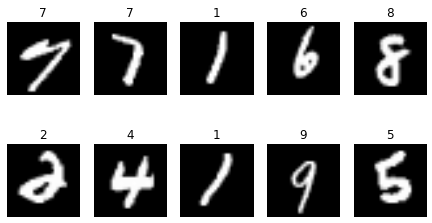

In [3]:
# Import data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Images are stored as matrices in numpy arrays
# Print a couple of images
fig = plt.figure(figsize=(7.5,4))
for i in range(10):
    idx = np.random.randint(0,60000)
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(x_train[idx],cmap=plt.get_cmap('gray'))
    ax.set_title(str(y_train[idx]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [4]:
# Normalize, transform to binary encoding and flatten the images
x_train = _normalize(x_train)
x_train = _convertBinary(x_train)
x_train = _flatten(x_train)

<h5> Optimizing the Bernoulli mixture </h5>

In [5]:

# Initialize random generator
np.random.seed(0)
# Set number of classes
K = 10
# Set number of images of the initial dataset we want
# to optimize on (to be chosen at random)
nsample = 5000
idx = np.random.randint(0,x_train.shape[0],size=nsample)
# Initialize mixture and Bernoulli coefficients
xtemp = x_train[idx,:]
M,N = xtemp.shape
mu,pi = _initialize(K,N)

# Maximum number of iterations to be performed
itermax = 10

# Start EM loop
start = time.time()
for i in range(itermax):
    print ("Iter: " + str(i))
    # Random permutation of the data
    xtemp = np.random.permutation(xtemp)
    # Estep
    gamma = _Estep(xtemp,mu,pi)
    # Mstep
    mu,pi = _Mstep(xtemp,gamma)
    
stop = time.time()
print ("Processing time: " + str(stop - start) + " s")

Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Processing time: 9.579877138137817 s


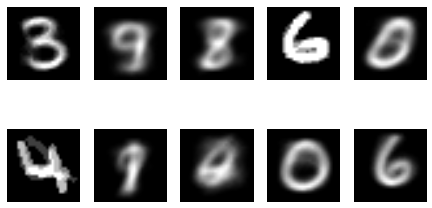

In [6]:
# Unflatten classes so that we can plot the values of the mu coefficients
mu_decoded = _decode(mu,28,28)
# Print the final classes
fig = plt.figure(figsize=(7.5,4))
for k in range(K):
    ax = fig.add_subplot(2,5,k+1)
    ax.imshow(mu_decoded[k],cmap=plt.get_cmap('gray'))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

<h2> 3. Results with C++ (much faster) code </h2>

I run the C++ code with the MNIST dataset using all the 60000 training images and for 50 iterations of the EM algorithm. Here I show the final values of the $\mu_k$.

In [7]:
# Load mu coefficients from file generated by the C++ implementation
c_mu = np.zeros((K,N),dtype=float)
k = 0;
for line in open("cpp/mu.dat"):
    c_mu[k] = (np.asarray([float(i) for i in line.split()]))
    k += 1

In [8]:
# Un-flatten coefficients so that we can plot them as images
c_mu_decoded = _decode(c_mu,28,28)

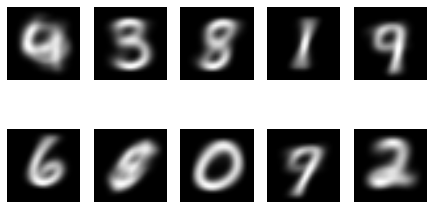

In [9]:
# Plot coefficients
fig = plt.figure(figsize=(7.5,4))
for k in range(K):
    ax = fig.add_subplot(2,5,k+1)
    ax.imshow(c_mu_decoded[k],cmap=plt.get_cmap('gray'))
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('cpp_train.png', bbox_inches='tight')
plt.show()

As we can see some of the numbers are easy for the algorithm to recognize, while some others are quite hard. In particular from the upper left corner we have the sequence: 4, 3, 8, 1, 9, 6, 5, 0, 7, 2.

We can notice that 9 and 7 are pretty similar, the 3 and the 8 as well and the number 4 and 5 are really hard to recognize (maybe due to the fact that people write them in many more different ways).
